In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler


train = pd.read_csv("/kaggle/input/mvp-subset/trainmod.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/mvp-subset/testmod.csv", index_col=[0])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train.shape

(4828800, 6)

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
print(train.columns)
feature_cols = ["R","C", "u_in", "u_out"]

Index(['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [5]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(60360, 80, 4) (60360, 80)


In [6]:
def get_model():
    act = "tanh"
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(n_steps,n_features)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=act),
        layers.Dense(256, activation=act),
        layers.Dense(512, activation=act),
        layers.Dense(80)
    ])
    return model
with strategy.scope():
    model = get_model()
    model.compile(optimizer="adam", loss="mae")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 300)          186000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 300)           0

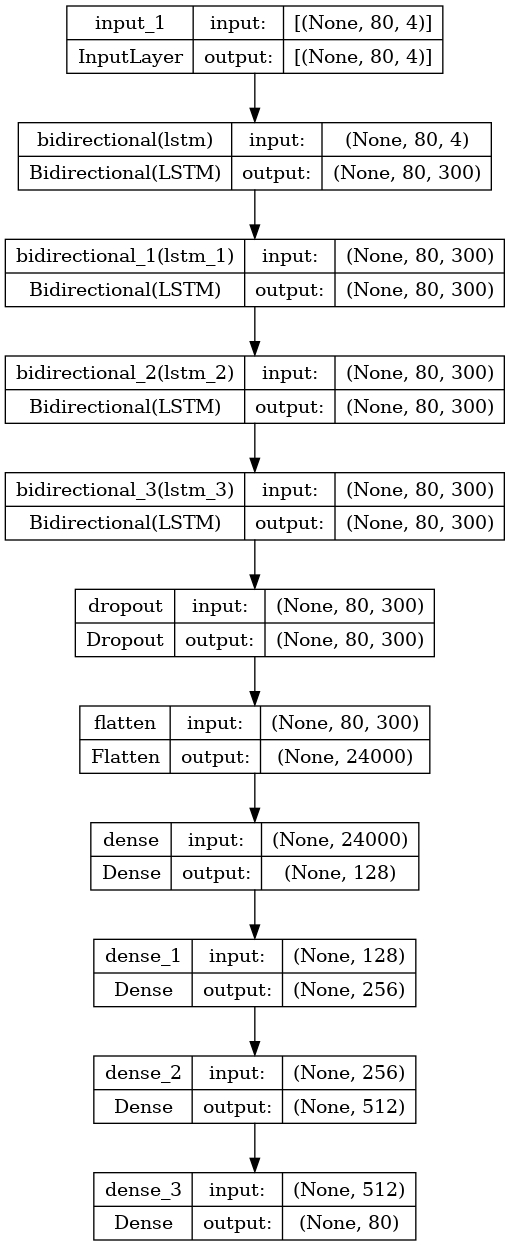

In [7]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [8]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=512, callbacks=[cb_es, cb_lr])

Epoch 1/200
95/95 [==============================] - 45s 254ms/step - loss: 4.0262 - val_loss: 3.0464 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 23s 238ms/step - loss: 3.0748 - val_loss: 3.0472 - lr: 9.9885e-04
Epoch 3/200
95/95 [==============================] - 22s 234ms/step - loss: 3.0741 - val_loss: 3.0445 - lr: 9.9770e-04
Epoch 4/200
95/95 [==============================] - 23s 240ms/step - loss: 3.0578 - val_loss: 2.9605 - lr: 9.9655e-04
Epoch 5/200
95/95 [==============================] - 23s 242ms/step - loss: 2.1858 - val_loss: 1.7041 - lr: 9.9541e-04
Epoch 6/200
95/95 [==============================] - 24s 250ms/step - loss: 1.6502 - val_loss: 1.6614 - lr: 9.9426e-04
Epoch 7/200
95/95 [==============================] - 24s 251ms/step - loss: 1.5845 - val_loss: 1.5383 - lr: 9.9312e-04
Epoch 8/200
95/95 [==============================] - 23s 244ms/step - loss: 1.5612 - val_loss: 1.5365 - lr: 9.9197e-04
Epoch 9/200
95/95 [==============================] -

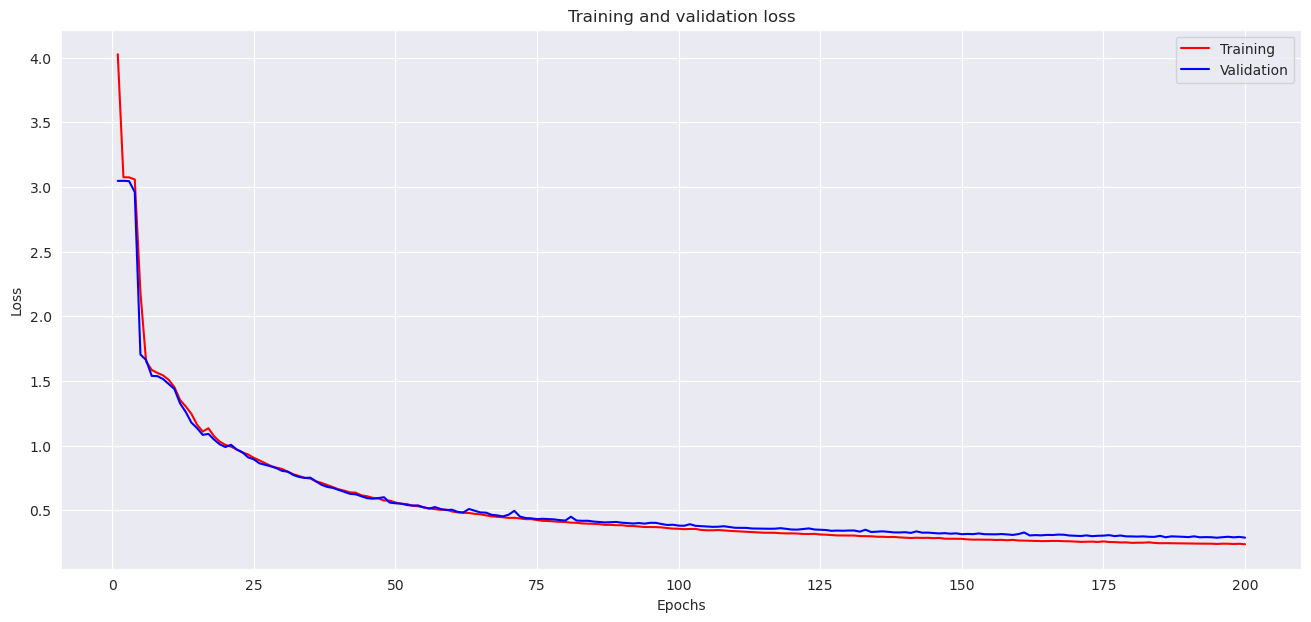

In [9]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

In [11]:
train = pd.read_csv("/kaggle/input/mvp-subset/trainmod.csv")
test = pd.read_csv("/kaggle/input/mvp-subset/testmod.csv")

In [12]:
feature_cols = ["R","C", "u_in", "u_out"]
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_test = len(test) // n_steps  # Calculate the number of breaths
y_test = test[target_column_name].values[:n_samples_test * n_steps].reshape(-1, n_steps)
X_test = test[feature_cols].values[:n_samples_test * n_steps].reshape(-1, n_steps, n_features)

print(X_test.shape, y_test.shape)

(15090, 80, 4) (15090, 80)


In [13]:
from sklearn.metrics import mean_absolute_error

1/1 [==============================] - 3s 3s/step
Mean Absolute Error (MAE): 0.17174352992668168


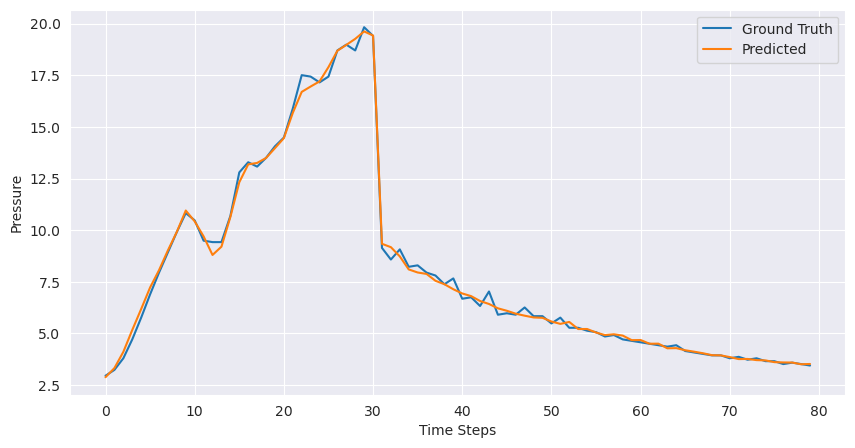

In [14]:
idx = 100616
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Calculate MAE
        mae = mean_absolute_error(y, p[0])

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p[0], label="Predicted")  # p[0] because there's only one prediction
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 3s 3s/step
Mean Absolute Error (MAE): 0.20649771105301715


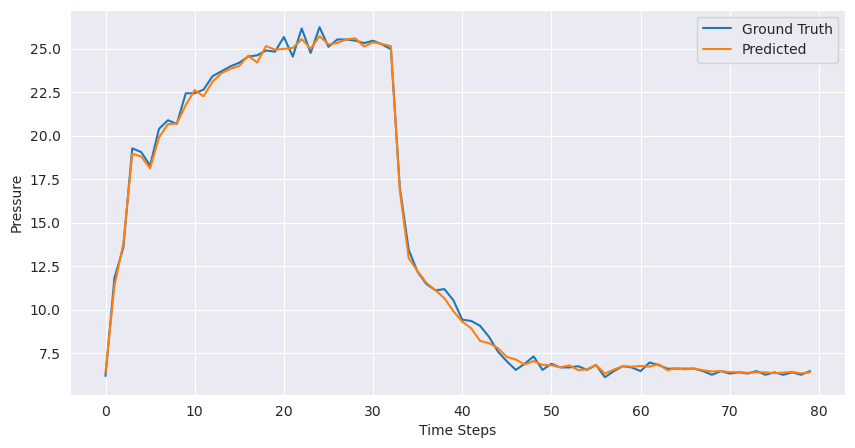

In [15]:
idx = 122413
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Calculate MAE
        mae = mean_absolute_error(y, p[0])

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p[0], label="Predicted")  # p[0] because there's only one prediction
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 3s 3s/step
Mean Absolute Error (MAE): 0.794392751371827


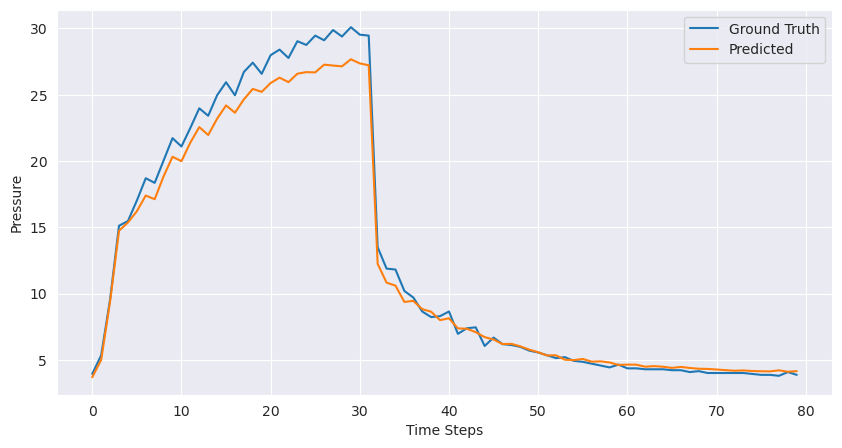

In [16]:
idx = 125749
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Calculate MAE
        mae = mean_absolute_error(y, p[0])

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p[0], label="Predicted")  # p[0] because there's only one prediction
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 3s 3s/step
Mean Absolute Error (MAE): 0.27696362830930976


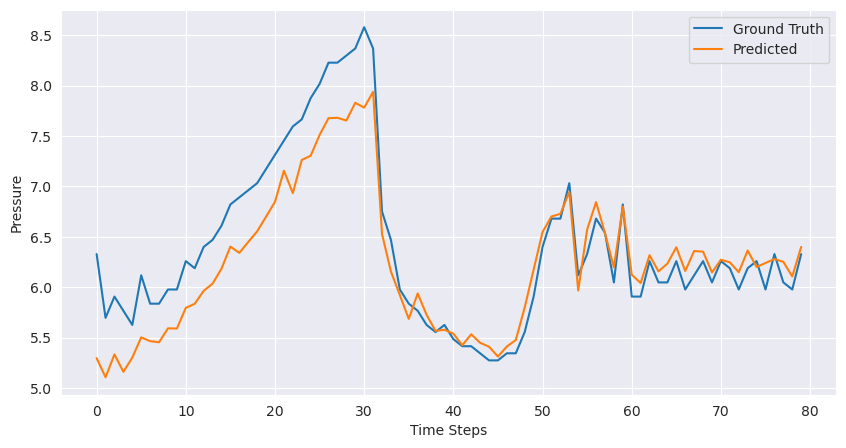

In [17]:
idx = 125680
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Calculate MAE
        mae = mean_absolute_error(y, p[0])

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p[0], label="Predicted")  # p[0] because there's only one prediction
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

In [18]:
model.save('model_increased_batch_size.keras')

In [19]:
model.save('model_increased_batch_size.h5')

In [20]:
lm= tf.keras.models.load_model('model_increased_batch_size.keras')

In [21]:
lmh5 = tf.keras.models.load_model('model_increased_batch_size.h5')

In [22]:
lm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 300)          186000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 300)           0

In [23]:
lmh5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 300)          186000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 300)           0